In [1]:
from itertools import combinations
from collections import deque

import wandb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from levers import IteratedLeverEnvironment
from levers.partners import FixedPatternPartner
from levers.learner import DQNAgent, DRQNetwork, DRQNAgent, Transition
from levers.helpers import generate_binary_patterns

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Helper Functions

In [3]:
# Class with dot notation access similar to wandb.config
class WandbDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
def ODQL_agent_from_config(
    env: IteratedLeverEnvironment, config: WandbDict
):
    # Create base class
    hist_rep = nn.LSTM(
        input_size=len(env.dummy_obs()),
        hidden_size=config.hist_rep_dim
    )
    learner = DQNAgent(
        q_net=nn.Sequential(
            nn.Linear(config.hist_rep_dim, config.dqn_hidden_dim),
            nn.ReLU(),
            nn.Linear(config.dqn_hidden_dim, env.n_actions()),
        ),
        capacity=0,
        batch_size=0,
        lr=config.dqn_lr,
        tau=config.dqn_tau,
        len_update_cycle=config.dqn_len_update_cycle,
        gamma=config.dqn_gamma,
        use_running_memory=config.dqn_use_running_memory,
    )

    # Load parameters from disk
    patterns = generate_binary_patterns(3)
    train_configurations = list(combinations(patterns, 4))
    train_patterns=train_configurations[config.exp_train_patterns_index]
    train_seed=config.exp_train_seed

    # Load history representation network's parameters
    hist_rep_name = f"odql_all_length3/models/hist-{train_patterns}-{train_seed}.pt"
    hist_rep.load_state_dict(torch.load(hist_rep_name))

    # Load Q-network's parameters
    q_net_name = f"odql_all_length3/models/q-{train_patterns}-{train_seed}.pt"
    learner.q_net.load_state_dict(torch.load(q_net_name))

    return hist_rep, learner

In [5]:
def DRQN_agent_from_config(
    env: IteratedLeverEnvironment, config: WandbDict
):
    # Load base class
    learner = DRQNAgent(
        q_net=DRQNetwork(
            rnn=nn.LSTM(
                input_size=len(env.dummy_obs()),
                hidden_size=config.drqn_rnn_hidden_dim,
                batch_first=True,
            ),
            fnn=nn.Sequential(
                nn.Linear(
                    in_features=config.drqn_rnn_hidden_dim,
                    out_features=config.drqn_fnn_hidden_dim,
                ),
                nn.ReLU(),
                nn.Linear(
                    in_features=config.drqn_fnn_hidden_dim,
                    out_features=env.n_actions(),
                ),
            ),
        ),
        capacity=config.drqn_capacity,
        batch_size=config.drqn_batch_size,
        lr=config.drqn_lr,
        tau=config.drqn_tau,
        gamma=config.drqn_gamma,
        len_update_cycle=config.drqn_len_update_cycle,
    )

    # Load parameters from disk
    patterns = generate_binary_patterns(3)
    train_configurations = list(combinations(patterns, 4))
    train_patterns=train_configurations[config.exp_train_patterns_index]
    train_seed=config.exp_train_seed

    # Load Q-network's parameters
    drqn_name = f"drqn_all_length3/models/q-{train_patterns}-{train_seed}.pt"
    learner.q_net.load_state_dict(torch.load(drqn_name))

    return learner

In [6]:
def eval_ODQL_learner(config, env, eps_start, eps_n_decay_steps):
    hist_rep, learner = ODQL_agent_from_config(env, config)

    # Prepare stats
    epi_return, epi_greedy_return, epi_n_greedy_steps = 0, 0, 0
    last_actions = deque(maxlen=4)

    # Reset environment and learner
    learner.reset()
    obs = env.reset()
    obs_rep, hidden = hist_rep(obs.unsqueeze(0))
    for step in range(env.episode_length - 1):
        eps = eps_start * max(1 - step / eps_n_decay_steps, 0)
        action, greedy = learner.act(obs_rep.squeeze(0), eps)
        next_obs, reward, done = env.step(action)
        next_obs_rep, next_hidden = hist_rep(next_obs.unsqueeze(0), hidden)
        learner.update_memory(
            Transition(
                obs_rep.squeeze(0).detach(),
                action,
                next_obs_rep.squeeze(0).detach(),
                reward,
                done,
            )
        )
        learner.train()
        epi_return += reward
        epi_greedy_return += reward if greedy else 0
        epi_n_greedy_steps += 1 if greedy else 0
        last_actions.append(action if greedy else -1)
        obs_rep = next_obs_rep
        hidden = next_hidden

    
    return {
        'return': epi_return,
        'normalized_greedy_return': epi_greedy_return / epi_n_greedy_steps * 100,
        'greedy_return': epi_greedy_return,
        'n_greedy_steps': epi_n_greedy_steps,
        'last_actions': last_actions
    }

In [7]:
def eval_DRQN_learner(config, env):
    learner = DRQN_agent_from_config(env, config)

    # Prepare stats
    epi_return = 0
    last_actions = deque(maxlen=4)

    # Reset environment and learner
    obs = env.reset()
    learner.reset_new_episode(init_obs=obs)
    for _ in range(env.episode_length - 1):
        action = learner.act(obs)
        last_actions.append(action)
        next_obs, reward, done = env.step(action)
        obs = next_obs
        epi_return += reward

    return {
        'return': epi_return,
        'last_actions': last_actions
    }

In [8]:
def eval_ODQL_crossplay(config1, config2, eps_start, eps_n_decay_steps):
    env = IteratedLeverEnvironment(
        payoffs=[1., 1.0],
        n_iterations=100+1,
        include_step=False,
        include_payoffs=False,
    )

    hist_rep1, agent1 = ODQL_agent_from_config(env, config1)
    hist_rep2, agent2 = ODQL_agent_from_config(env, config2)

    # Prepare stats
    epi_return, epi_greedy_return, epi_n_greedy_steps = 0, 0, 0
    last_actions = deque(maxlen=4)

    joint_obs = env.reset()

    agent1.reset()
    agent2.reset()

    obs_rep1, hidden1 = hist_rep1(joint_obs[0].unsqueeze(0))
    obs_rep2, hidden2 = hist_rep2(joint_obs[1].unsqueeze(0))

    for step in range(env.episode_length - 1):
        # Get agents' actions
        eps = eps_start * max(1 - step / eps_n_decay_steps, 0)
        action1, greedy1 = agent1.act(obs_rep1.squeeze(0), eps)
        action2, greedy2 = agent2.act(obs_rep2.squeeze(0), eps)

        next_joint_obs, reward, done = env.step([action1, action2])

        next_obs_rep1, hidden1 = hist_rep1(next_joint_obs[0].unsqueeze(0), hidden1)
        next_obs_rep2, hidden2 = hist_rep2(next_joint_obs[1].unsqueeze(0), hidden2)

        # Train agent 1
        agent1.update_memory(
            Transition(
                obs_rep1.squeeze(0).detach(),
                action1,
                next_obs_rep1.squeeze(0).detach(),
                reward,
                done,
            )
        )
        agent1.train()

        # Train agent 2
        agent2.update_memory(
            Transition(
                obs_rep2.squeeze(0).detach(),
                action2,
                next_obs_rep2.squeeze(0).detach(),
                reward,
                done,
            )
        )
        agent2.train()

        # Update stats
        epi_return += reward
        epi_greedy_return += reward if greedy1 and greedy2 else 0
        epi_n_greedy_steps += 1 if greedy1 and greedy2 else 0

        # Prepare next step
        obs_rep1 = next_obs_rep1
        obs_rep2 = next_obs_rep2

    return {
        'return': epi_return,
        'normalized_greedy_return': epi_greedy_return / epi_n_greedy_steps * 100,
        'greedy_return': epi_greedy_return,
        'n_greedy_steps': epi_n_greedy_steps,
        'last_actions': last_actions
    }

    

In [9]:
def eval_DRQN_crossplay(config1, config2):
    env = IteratedLeverEnvironment(
        payoffs=[1., 1.],
        n_iterations=100+1,
        include_step=False,
        include_payoffs=False,
    )

    agent1 = DRQN_agent_from_config(env, config1)
    agent2 = DRQN_agent_from_config(env, config2)

    joint_obs = env.reset()
    agent1.reset()
    agent2.reset()

    epi_return = 0
    for step in range(env.episode_length - 1):
        action1 = agent1.act(joint_obs[0])
        action2 = agent2.act(joint_obs[1])
        next_joint_obs, reward, _ = env.step([action1, action2])
        epi_return += reward
        joint_obs = next_joint_obs

    return {
        'return': epi_return
    }

## General Setup

In [10]:
patterns = generate_binary_patterns(3)
train_configurations = list(combinations(patterns, 4))

envs = [
    IteratedLeverEnvironment(
        payoffs=[1., 1.],
        n_iterations=100 + 1,
        partner=FixedPatternPartner(pattern),
        include_step=False,
        include_payoffs=False,
    )
    for pattern in patterns
]

## ODQL Agent Evaluation

In [11]:
api = wandb.Api(timeout=60)

# Obtain runs from ODQL parameter sweep
runs = api.runs("hericks/odql-all-length3")

# Obtain parameter configs for each run
configs = []
for run in runs: 
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    configs.append(WandbDict(config))

# Obtain number of training seeds per configuration
n_train_seeds = max([config.exp_train_seed for config in configs]) + 1
print(f"The ODQL agents were trained for {n_train_seeds} different seeds each.")

The ODQL agents were trained for 15 different seeds each.


In [12]:
results_list = []
for config_index, config in enumerate(configs):
    if (config_index + 1) % 200 == 0:
        print(config_index + 1)
    for eval_index, eval_pattern in enumerate(patterns):
        results = eval_ODQL_learner(
            config=config,
            env=envs[eval_index],
            eps_start=1.0,
            eps_n_decay_steps=33,
        )
        results.update({
            'method': 'ODQL',
            'train_patterns': train_configurations[config.exp_train_patterns_index],
            'train_seed': config.exp_train_seed,
            'eval_pattern': eval_pattern,
            'seen_at_train_time': eval_pattern in train_configurations[config.exp_train_patterns_index],
        })
        results_list.append(results)

odql_results_df = pd.DataFrame(results_list)

200
400
600
800
1000


In [13]:
odql_results_df = odql_results_df[['method', 'train_patterns', 'train_seed', 'eval_pattern', 'seen_at_train_time', 'return', 'normalized_greedy_return', 'greedy_return', 'n_greedy_steps', 'last_actions']]
odql_results_df

,method,train_patterns,train_seed,eval_pattern,seen_at_train_time,return,normalized_greedy_return,greedy_return,n_greedy_steps,last_actions
0,ODQL,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 0, 0)",False,89.0,95.348837,82.0,86,"[0, 0, 0, 0]"
1,ODQL,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 0, 1)",False,65.0,65.853659,54.0,82,"[0, 1, 1, 0]"
2,ODQL,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 1, 0)",False,65.0,67.073171,55.0,82,"[1, 1, 0, 1]"
3,ODQL,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 1, 1)",False,90.0,98.823529,84.0,85,"[0, 1, 1, 0]"
4,ODQL,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(1, 0, 0)",True,62.0,62.962963,51.0,81,"[0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...
8395,ODQL,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(0, 1, 1)",True,93.0,100.000000,87.0,87,"[0, 1, 1, 0]"
8396,ODQL,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 0, 0)",False,89.0,98.795181,82.0,83,"[1, 0, 0, 1]"
8397,ODQL,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 0, 1)",False,57.0,65.853659,54.0,82,"[1, 0, 0, 1]"
8398,ODQL,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 1, 0)",False,93.0,100.000000,82.0,82,"[1, 1, 0, 1]"


In [14]:
train = odql_results_df['seen_at_train_time']
print(f"Overall: {odql_results_df['return'].mean():.2f} | {odql_results_df['normalized_greedy_return'].mean():.2f}")
print(f"Train: {odql_results_df[train]['return'].mean():.2f} | {odql_results_df[train]['normalized_greedy_return'].mean():.2f}")
print(f"Test: {odql_results_df[~train]['return'].mean():.2f} | {odql_results_df[~train]['normalized_greedy_return'].mean():.2f}")

Overall: 88.18 | 95.99
Train: 90.03 | 98.22
Test: 86.33 | 93.76



## DRQN Agent Evaluation

In [15]:
api = wandb.Api(timeout=60)

# Obtain runs from ODQL parameter sweep
runs = api.runs("hericks/drqn-all-length3")

# Obtain parameter configs for each run
configs = []
for run in runs: 
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    configs.append(WandbDict(config))

# Obtain number of training seeds per configuration
n_train_seeds = max([config.exp_train_seed for config in configs]) + 1
print(f"The DRQN agents were trained for {n_train_seeds} different seeds each.")

The DRQN agents were trained for 15 different seeds each.


In [16]:
results_list = []
for config_index, config in enumerate(configs):
    if (config_index + 1) % 200 == 0:
        print(config_index + 1)
    for eval_index, eval_pattern in enumerate(patterns):
        try:
            results = eval_DRQN_learner(
                config=config,
                env=envs[eval_index],
            )
            results.update({
                'method': 'DRQN',
                'train_patterns': train_configurations[config.exp_train_patterns_index],
                'train_seed': config.exp_train_seed,
                'eval_pattern': eval_pattern,
                'seen_at_train_time': eval_pattern in train_configurations[config.exp_train_patterns_index],
            })
            results_list.append(results)
        except:
            pass

drqn_results_df = pd.DataFrame(results_list)

200
400
600
800
1000


In [17]:
drqn_results_df = drqn_results_df[['method', 'train_patterns', 'train_seed', 'eval_pattern', 'seen_at_train_time', 'return', 'last_actions']]
drqn_results_df

,method,train_patterns,train_seed,eval_pattern,seen_at_train_time,return,last_actions
0,DRQN,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 0, 0)",False,0.0,"[1, 1, 1, 1]"
1,DRQN,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 0, 1)",False,98.0,"[0, 0, 1, 0]"
2,DRQN,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 1, 0)",False,98.0,"[0, 1, 0, 0]"
3,DRQN,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(0, 1, 1)",False,99.0,"[0, 1, 1, 0]"
4,DRQN,"((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",14,"(1, 0, 0)",True,100.0,"[1, 0, 0, 1]"
...,...,...,...,...,...,...,...
8395,DRQN,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(0, 1, 1)",True,34.0,"[0, 0, 0, 0]"
8396,DRQN,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 0, 0)",False,66.0,"[0, 0, 0, 0]"
8397,DRQN,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 0, 1)",False,33.0,"[0, 0, 0, 0]"
8398,DRQN,"((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))",0,"(1, 1, 0)",False,33.0,"[0, 0, 0, 0]"


In [18]:
train = drqn_results_df['seen_at_train_time']
print(f"Overall: {drqn_results_df['return'].mean():.2f}")
print(f"Train: {drqn_results_df[train]['return'].mean():.2f}")
print(f"Test: {drqn_results_df[~train]['return'].mean():.2f}")

Overall: 85.65
Train: 97.31
Test: 74.00


## Joint Visualization

## Prepare Crossplay Analysis

In [19]:
patterns = generate_binary_patterns(3)
all_train_configurations = list(combinations(patterns, 4))
n_train_configurations = len(all_train_configurations)

n_xplay = 15
xplay_train_configurations_indices = random.sample(range(n_train_configurations), n_xplay)

## ODQL Crossplay Analysis

In [20]:
api = wandb.Api(timeout=60)

needed_dict = {
    i: False if i not in xplay_train_configurations_indices else True
    for i in range(n_train_configurations)
}

# Obtain runs from ODQL parameter sweep
runs = api.runs("hericks/odql-all-length3")

# Obtain parameter configs for each run
crossplay_configs = []
for run in runs: 
    config = WandbDict({k:v for k,v in run.config.items() if not k.startswith('_')})
    if needed_dict[config.exp_train_patterns_index]:
        crossplay_configs.append(WandbDict(config))
        needed_dict[config.exp_train_patterns_index] = False


In [21]:
rows_list = []
for i in range(n_xplay):
    if (i + 1) % 5 == 0:
        print(i + 1)
    for j in range(n_xplay):
        res = eval_ODQL_crossplay(crossplay_configs[i], crossplay_configs[j], 0.5, 30)
        res.update({
            "i1": i,
            "i2": j,
            "i1_train_patterns": all_train_configurations[crossplay_configs[i].exp_train_patterns_index],
            "i2_train_patterns": all_train_configurations[crossplay_configs[j].exp_train_patterns_index],
        })
        rows_list.append(res)

odql_xplay_df = pd.DataFrame(rows_list)
odql_xplay_df = odql_xplay_df[['i1', 'i2', 'i1_train_patterns', 'i2_train_patterns', 'return', 'normalized_greedy_return', 'greedy_return', 'n_greedy_steps', 'last_actions']]

5
10
15


In [22]:
odql_xplay_df

,i1,i2,i1_train_patterns,i2_train_patterns,return,normalized_greedy_return,greedy_return,n_greedy_steps,last_actions
0,0,0,"((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))","((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))",80.0,85.057471,74.0,87,[]
1,0,1,"((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))","((0, 1, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1))",92.0,93.333333,84.0,90,[]
2,0,2,"((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))","((0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))",93.0,97.802198,89.0,91,[]
3,0,3,"((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))","((0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1))",92.0,96.511628,83.0,86,[]
4,0,4,"((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1))","((0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0))",87.0,93.181818,82.0,88,[]
...,...,...,...,...,...,...,...,...,...
220,14,10,"((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1))","((0, 0, 0), (0, 1, 1), (1, 0, 0), (1, 1, 0))",78.0,81.927711,68.0,83,[]
221,14,11,"((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1))","((0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1))",90.0,96.511628,83.0,86,[]
222,14,12,"((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1))","((0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 0, 1))",49.0,48.863636,43.0,88,[]
223,14,13,"((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1))","((0, 0, 0), (0, 0, 1), (1, 1, 0), (1, 1, 1))",95.0,100.000000,89.0,89,[]


In [23]:
print(f"ODQL Crossplay: {odql_xplay_df['return'].mean():.2f} | {odql_xplay_df['normalized_greedy_return'].mean():.2f} (greedy)")

ODQL Crossplay: 71.84 | 74.70 (greedy)


In [24]:
odql_xplay_returns = np.zeros((n_xplay, n_xplay))
odql_xplay_normalized_greedy_returns = np.zeros((n_xplay, n_xplay))
for i in range(n_xplay):
    for j in range(n_xplay):
        row_mask = (odql_xplay_df['i1'] == i) & (odql_xplay_df['i2'] == j)
        odql_xplay_returns[i, j] = odql_xplay_df[row_mask]['return'].item()
        odql_xplay_normalized_greedy_returns[i, j] = odql_xplay_df[row_mask]['normalized_greedy_return'].item()

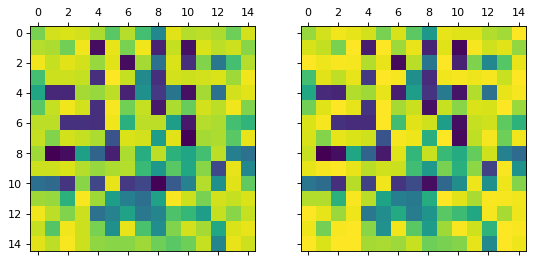

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 16), dpi=80)
ax1.matshow(odql_xplay_returns)
ax2.matshow(odql_xplay_normalized_greedy_returns)

## DRQN Crossplay Analysis

In [26]:
api = wandb.Api(timeout=60)

needed_dict = {
    i: False if i not in xplay_train_configurations_indices else True
    for i in range(n_train_configurations)
}

# Obtain runs from DRQN parameter sweep
runs = api.runs("hericks/drqn-all-length3")

# Obtain parameter configs for each run
crossplay_configs = []
for run in runs: 
    config = WandbDict({k:v for k,v in run.config.items() if not k.startswith('_')})
    if needed_dict[config.exp_train_patterns_index]:
        crossplay_configs.append(WandbDict(config))
        needed_dict[config.exp_train_patterns_index] = False


In [27]:
rows_list = []
for i in range(n_xplay):
    if (i + 1) % 5 == 0:
        print(i + 1)
    for j in range(n_xplay):
        res = eval_DRQN_crossplay(crossplay_configs[i], crossplay_configs[j])
        res.update({
            "i1": i,
            "i2": j,
            "i1_train_patterns": all_train_configurations[crossplay_configs[i].exp_train_patterns_index],
            "i2_train_patterns": all_train_configurations[crossplay_configs[j].exp_train_patterns_index],
        })
        rows_list.append(res)

drqn_xplay_df = pd.DataFrame(rows_list)
drqn_xplay_df = drqn_xplay_df[['i1', 'i2', 'i1_train_patterns', 'i2_train_patterns', 'return']]

5
10
15


In [28]:
drqn_xplay_df['return']

0      100.0
1       67.0
2      100.0
3       67.0
4       67.0
       ...  
220    100.0
221     35.0
222      2.0
223    100.0
224    100.0
Name: return, Length: 225, dtype: float64

In [29]:
print(f"Crossplay: {drqn_xplay_df['return'].mean():.2f}")

Crossplay: 50.23


In [30]:
drqn_xplay_returns = np.zeros((n_xplay, n_xplay))
for i in range(n_xplay):
    for j in range(n_xplay):
        row_mask = (drqn_xplay_df['i1'] == i) & (drqn_xplay_df['i2'] == j)
        drqn_xplay_returns[i, j] = drqn_xplay_df[row_mask]['return'].item()

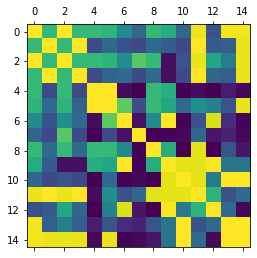

In [31]:
plt.matshow(drqn_xplay_returns)